### Imports and utils

In [1]:
import re, glob, json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract Timeloop Statistics from output files
def extract_tl_stats(file_path):
  with open(file_path, "r") as f:
    stats = f.read()

    res = re.findall(r'Utilization:\s(\d+.\d+)\s', stats, re.DOTALL)
    utilization = float(res[0])

    res = re.findall(r'Total\s+= (\d+.\d+)\s', stats, re.DOTALL)
    efficiency = float(res[0])

    res = re.findall(r'Cycles:\s(\d+)', stats, re.DOTALL)
    cycles = int(res[0])

    res = re.findall(r'Energy:\s(\d+.\d+)\suJ', stats, re.DOTALL)
    energy = float(res[0])

    f.close()

  return utilization, efficiency, cycles, energy

# Plot Styling
font_size = 8
_new_black = '#373737'
color_grid = '#F1F5B7'
color1 = '#EBF095'
color2 = '#DEE600'
sns.set_theme(style='ticks', font_scale=0.75, rc={
    'font.family': 'serif',
    'font.serif': ['Linux Libertine O'],
    'svg.fonttype': 'none',
    'text.usetex': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': font_size,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'axes.labelpad': 2,
    'axes.linewidth': 1,
    'axes.titlepad': 4,
    'lines.linewidth': 1,
    'legend.fontsize': font_size,
    'legend.title_fontsize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'xtick.major.size': 2,
    'xtick.major.pad': 1,
    'xtick.major.width': 1,
    'ytick.major.size': 2,
    'ytick.major.pad': 1,
    'ytick.major.width': 1,
    'xtick.minor.size': 2,
    'xtick.minor.pad': 1,
    'xtick.minor.width': 1,
    'ytick.minor.size': 2,
    'ytick.minor.pad': 1,
    'ytick.minor.width': 1,
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False,
    'hatch.color': _new_black,
    'axes.edgecolor': _new_black,
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black,
    'figure.figsize': (3.34,1.5),
    'axes.grid' : True,
    'grid.color': color_grid,
})

### EDP Comparison

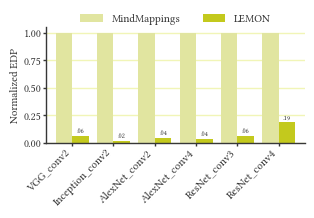

In [2]:
plot_ref = False # Set true to plot reference results
ref_sfx = '-ref' if plot_ref else ''

layer_names = ['VGG_conv2', 'Inception_conv2', 'AlexNet_conv2', 'AlexNet_conv4', 'ResNet_conv3', 'ResNet_conv4']

data = pd.DataFrame()
for method, method_name in zip(['mindmappings', 'lemon'], ['MindMappings', 'LEMON']):
    for i, layer_name in enumerate(layer_names):
        stats_file = glob.glob(f'./results{ref_sfx}/{method}/{i}/*.stats.txt')[0]
        utilization, efficiency, cycles, energy = extract_tl_stats(stats_file)

        with open(f'./results{ref_sfx}/{method}/runtime.json', 'r') as runtime_file:
            runtime_dict = json.load(runtime_file)
            runtime = runtime_dict[str(i)]

        df_dict = {
          'Method': method_name,
          'Layer': layer_name,
          'Energy [uJ]': energy,
          'Cycles': cycles,
          'EDP': energy*cycles,
          'Runtime [s]': runtime,
        }
        data = pd.concat([data, pd.DataFrame(df_dict, index=[0])])

data['Normalized EDP'] = data.groupby('Layer')['EDP'].transform(lambda x: x/x.max())
g = sns.barplot(data, x='Layer', y='Normalized EDP', hue='Method', palette=[color1, color2])
plt.xticks(rotation=45, ha='right')
sns.move_legend(
    g, "upper center",
    bbox_to_anchor=(0.5, 1.2), ncol=2, title=None, frameon=False,
)
g.margins(x=0.04)

for p in g.patches:
    if p.get_height() < 1.0:
        g.annotate(f'{p.get_height():.2f}'.lstrip('0'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0.1, 3.3), 
                    textcoords = 'offset points', fontsize=5)

sns.despine()
_ = g.set_xlabel(None)

#plt.savefig('mindmappings.pdf', bbox_inches='tight', pad_inches = 0)


### Runtime Comparison

- Ignoring MindMappings surrogate model training time...
- In the order of seconds for both methods

         Method            Layer  Energy [uJ]     Cycles           EDP   
0  MindMappings        VGG_conv2    358475.75  462422016  1.657671e+14  \
0  MindMappings  Inception_conv2    867060.52  346816512  3.007109e+14   
0  MindMappings    AlexNet_conv2    119822.22  111974400  1.341702e+13   
0  MindMappings    AlexNet_conv4    105407.38   37380096  3.940138e+12   
0  MindMappings     ResNet_conv3     89244.85   28901376  2.579299e+12   
0  MindMappings     ResNet_conv4     28843.59   28901376  8.336194e+11   
0         LEMON        VGG_conv2    172035.33   57802752  9.944116e+12   
0         LEMON  Inception_conv2    128570.69   43352064  5.573805e+12   
0         LEMON    AlexNet_conv2     40634.56   13996800  5.687538e+11   
0         LEMON    AlexNet_conv4     20819.48    7008768  1.459189e+11   
0         LEMON     ResNet_conv3     21471.44    7225344  1.551385e+11   
0         LEMON     ResNet_conv4     21465.80    7225344  1.550978e+11   

   Runtime [s]  Normalized EDP  
0   

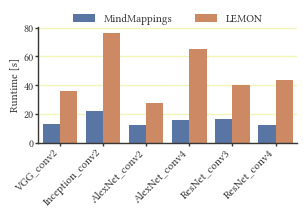

In [3]:
print(data)

data['Normalized Runtime'] = data.groupby('Layer')['Runtime [s]'].transform(lambda x: x/x.max())

g = sns.barplot(data, x='Layer', y='Runtime [s]', hue='Method')
_ = plt.xticks(rotation=45, ha='right')
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 1.2), ncol=2, title=None, frameon=False)
sns.despine()
_ = g.set_xlabel(None)